# Creacion de los modelos

# Fase de Modelado: Predicción de Default

En esta etapa, utilizaremos la base preparada en el EDA para entrenar y evaluar distintos modelos de clasificación. El objetivo es identificar qué algoritmo separa mejor a los clientes que cumplen de aquellos que caen en impago (default).

## Preparación de Datos
Comenzamos cargando los datos limpios y realizando la partición de entrenamiento y prueba respetando la temporalidad (OOT - Out of Time) para simular un escenario real.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, precision_recall_curve)


In [3]:

apps_model = pd.read_csv('data/clean/apps_model_filtered.csv', parse_dates=['orig_month'], thousands=',')
apps_model

,customer_id,orig_month,age,income,debt_income,bureau_score,utilization,prev_delin_24m,tenure_months,amount,...,rate,infl,default_12m,months_since_orig,product_CC,product_PL,channel_Digital,channel_Partner,region_N,region_S
0,2,2024-01-03,34,103244.98,0.3936,691.9,0.1771,1,17,45248.85,...,7.375842,4.507775,0,12.155059,0,1,0,1,0,0
1,3,2024-01-05,31,41568.33,0.5023,653.2,0.4781,0,68,308801.45,...,7.384582,4.868222,1,12.089356,0,0,1,0,0,0
2,5,2024-01-01,50,12633.20,0.1435,681.7,0.1931,0,40,92093.10,...,7.382953,4.249541,0,12.220762,0,1,1,0,0,0
3,8,2022-01-10,29,24126.21,0.3842,603.6,0.2423,1,17,84014.16,...,6.908256,4.278983,0,35.906702,0,1,1,0,1,0
4,9,2022-01-03,21,34684.79,0.4979,702.9,0.0808,0,81,22040.43,...,6.886504,4.319146,0,36.136662,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18421,24993,2022-01-04,57,30805.18,0.3133,623.7,0.6330,0,82,38923.00,...,7.088503,4.285473,1,36.103811,0,1,1,0,0,1
18422,24995,2024-01-04,47,37852.79,0.2701,668.7,0.4662,0,50,69841.34,...,7.176895,4.608903,0,12.122208,0,1,1,0,0,0
18423,24996,2023-01-07,38,30300.98,0.2434,721.2,0.6266,1,3,46228.76,...,7.137931,4.360457,0,24.014455,1,0,0,1,0,1
18424,24998,2024-01-06,50,19879.46,0.4391,533.4,0.3975,0,15,33748.71,...,7.444711,4.886401,0,12.056505,0,1,1,0,0,1


In [4]:
apps_sorted = apps_model.sort_values('orig_month')


In [5]:
cutoff = apps_sorted['orig_month'].quantile(0.8)

train = apps_sorted[apps_sorted['orig_month'] <= cutoff]
test  = apps_sorted[apps_sorted['orig_month'] > cutoff]


### Definición de Features y Target
Separamos nuestra variable objetivo (`default_12m`) de los predictores. Excluimos identificadores y fechas que no aportan valor predictivo directo.


In [6]:
features = apps_sorted.columns.difference(['customer_id','orig_month','default_12m'])

X_train = train[features]
y_train = train['default_12m']

X_test = test[features]
y_test = test['default_12m']



### Escalado de Variables
Para modelos sensibles a la magnitud (como la Regresión Logística), estandarizamos las variables numéricas.


In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


### Análisis de Multicolinealidad
Revisamos la correlación entre variables para evitar redundancias que puedan afectar la estabilidad de los coeficientes en modelos lineales.


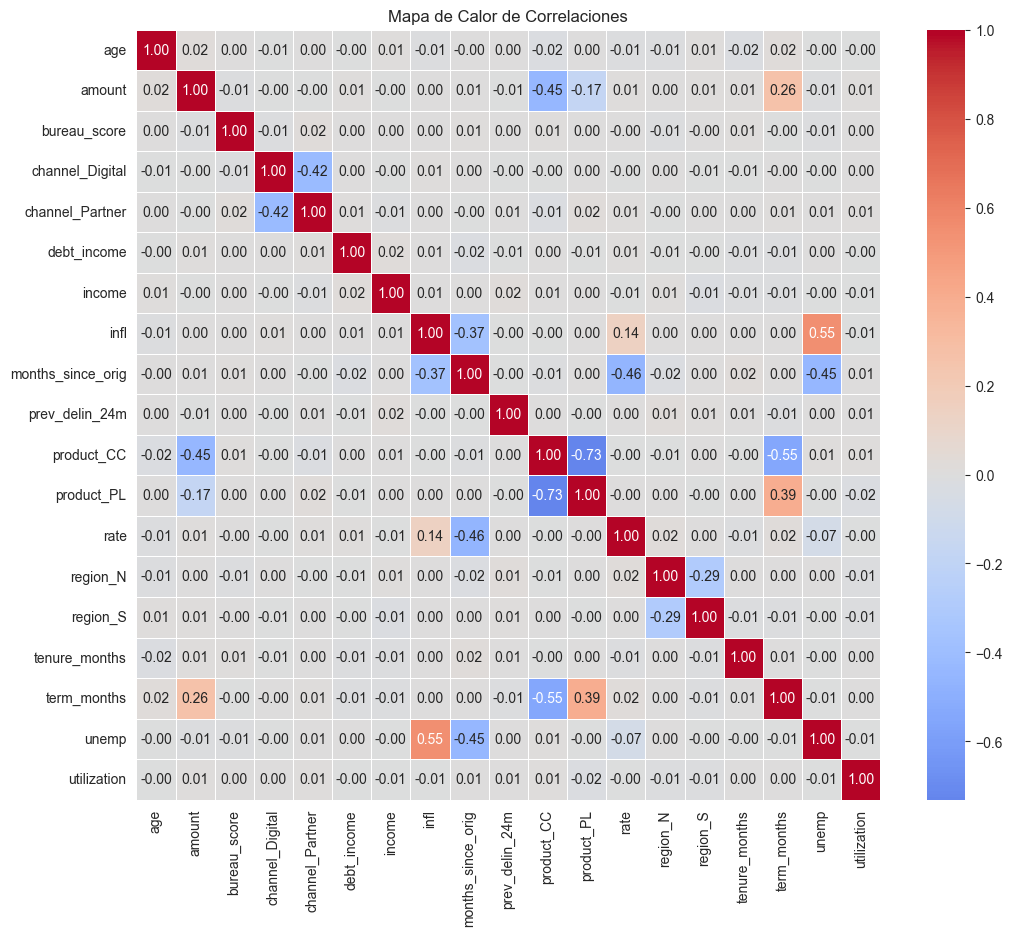

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculamos la matriz de correlación del set escalado
corr_matrix = X_train_scaled.corr()

# 2. Configuramos el tamaño de la figura
plt.figure(figsize=(12, 10))

# 3. Creamos el mapa de calor
sns.heatmap(
    corr_matrix,
    annot=True,          # Muestra los números en cada celda
    fmt=".2f",           # Limita a 2 decimales
    cmap='coolwarm',     # Color: azul (negativo), rojo (positivo)
    linewidths=0.5,      # Espacio entre celdas
    center=0             # El blanco será el valor 0 (sin correlación)
)

plt.title('Mapa de Calor de Correlaciones')
plt.show()

## 1. Regresión Logística
Iniciamos con un modelo base de Regresión Logística. Primero probamos con todas las variables para identificar significancia estadística.


In [9]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.197061
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            default_12m   No. Observations:                14789
Model:                          Logit   Df Residuals:                    14769
Method:                           MLE   Df Model:                           19
Date:                Tue, 10 Feb 2026   Pseudo R-squ.:                 0.03570
Time:                        20:12:39   Log-Likelihood:                -2914.3
converged:                       True   LL-Null:                       -3022.2
Covariance Type:            nonrobust   LLR p-value:                 2.399e-35
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.0357      0.041    -73.218      0.000      -3.117      -2.954
age     

### Selección de Variables (Modelo Reducido)
Basándonos en el p-value y el sentido de negocio, seleccionamos las variables con mayor impacto para simplificar el modelo sin perder capacidad predictiva.


In [10]:
good_vars = [
    'bureau_score',
    'debt_income',
    'income',
    'infl',
    'prev_delin_24m',
    'rate',
    'utilization'
]
X_train_red = X_train[good_vars]
X_test_red  = X_test[good_vars]
scaler = StandardScaler()

X_train_red_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_red),
    columns=good_vars,
    index=X_train_red.index
)

X_test_red_scaled = pd.DataFrame(
    scaler.transform(X_test_red),
    columns=good_vars,
    index=X_test_red.index
)
X_test_red_scaled

,bureau_score,debt_income,income,infl,prev_delin_24m,rate,utilization
16631,-1.068490,-1.206726,-0.434468,0.715100,-0.594043,2.324148,-1.614446
5394,0.757546,-0.239370,1.386605,0.715100,-0.594043,2.324148,1.928552
18076,-0.896843,-0.257179,-1.248735,0.715100,2.861335,2.324148,0.816739
1044,1.106319,-0.136260,-0.120000,0.715100,-0.594043,2.324148,1.389900
1005,0.036262,1.968115,1.862712,0.715100,-0.594043,2.324148,-0.587657
...,...,...,...,...,...,...,...
2404,0.257212,-0.221091,0.322913,4.009866,-0.594043,2.615516,-0.038002
17627,1.095363,-0.042055,-0.135984,4.009866,-0.594043,2.615516,-0.626668
17628,-1.448306,-1.093774,-0.096810,4.009866,-0.594043,2.615516,0.203566
7073,-1.070316,0.216188,-0.525438,4.009866,-0.594043,2.615516,-1.540925


In [11]:
X_train_sm_red = sm.add_constant(X_train_red_scaled)

logit_red = sm.Logit(y_train, X_train_sm_red)
result_red = logit_red.fit()

print(result_red.summary())

Optimization terminated successfully.
         Current function value: 0.198061
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            default_12m   No. Observations:                14789
Model:                          Logit   Df Residuals:                    14781
Method:                           MLE   Df Model:                            7
Date:                Tue, 10 Feb 2026   Pseudo R-squ.:                 0.03081
Time:                        20:12:39   Log-Likelihood:                -2929.1
converged:                       True   LL-Null:                       -3022.2
Covariance Type:            nonrobust   LLR p-value:                 9.368e-37
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0179      0.041    -73.781      0.000      -3.098      -2.938
bureau_score     

In [12]:
comparacion = pd.DataFrame({
    'Modelo': ['Completo (19 vars)', 'Reducido (7 vars)'],
    'Pseudo R': [result.prsquared, result_red.prsquared],
    'AIC': [result.aic, result_red.aic],
    'BIC': [result.bic, result_red.bic],
    'Log-Likelihood': [result.llf, result_red.llf]
})
print(comparacion)


               Modelo  Pseudo R          AIC          BIC  Log-Likelihood
0  Completo (19 vars)  0.035701  5868.678246  6020.711025    -2914.339123
1   Reducido (7 vars)  0.030811  5874.234578  5935.047689    -2929.117289


In [13]:
X_test_sm_red = sm.add_constant(X_test_red_scaled)
y_pred_proba = result_red.predict(X_test_sm_red)

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)


AUC: 0.6398739515968646


## Regresión Logística Balanceada (scikit-learn)
Probamos la implementación de scikit-learn con el parámetro `class_weight='balanced'`.


In [15]:
from sklearn.linear_model import LogisticRegression

# Con scikit-learn (más simple)
logit_balanced = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

logit_balanced.fit(X_train_red_scaled, y_train)
y_pred_logit_balanced = logit_balanced.predict_proba(X_test_red_scaled)[:, 1]

# Métricas Logit
auc_logit = roc_auc_score(y_test, y_pred_logit_balanced)
gini_logit = 2 * auc_logit - 1

# KS Logit
scores_logit_0 = y_pred_logit_balanced[y_test == 0]
scores_logit_1 = y_pred_logit_balanced[y_test == 1]
ks_logit = stats.ks_2samp(scores_logit_0, scores_logit_1).statistic

print(f"AUC:  {auc_logit:.4f}")
print(f"Gini: {gini_logit:.4f}")
print(f"KS:   {ks_logit:.4f}")

AUC:  0.6361
Gini: 0.2721
KS:   0.2101


## 2. Modelos Basados en Árboles (XGBoost)
A diferencia de la logística, los árboles de decisión capturan relaciones no lineales y no requieren escalado. Probamos una versión "Baseline" sin ajustes de balance.


In [16]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Usa las 19 variables originales SIN escalar
# (XGBoost no requiere escalado)
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    eval_metric='auc'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Métricas XGBoost Baseline
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
gini_xgb = 2 * auc_xgb - 1

# KS XGBoost Baseline
scores_xgb_0 = y_pred_xgb[y_test == 0]
scores_xgb_1 = y_pred_xgb[y_test == 1]
ks_xgb = stats.ks_2samp(scores_xgb_0, scores_xgb_1).statistic

print(f"AUC:  {auc_xgb:.4f}")
print(f"Gini: {gini_xgb:.4f}")
print(f"KS:   {ks_xgb:.4f}")

AUC:  0.6022
Gini: 0.2044
KS:   0.1770


### XGBoost Balanced
Dado que el default es un evento poco frecuente, ajustamos el peso de las clases para que el modelo preste más atención a los casos positivos (Default).


In [17]:
# Seccion de XGBoost Balanced
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
ratio = neg / pos

xgb_balanced = xgb.XGBClassifier(
    scale_pos_weight=ratio,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='auc'
)

xgb_balanced.fit(X_train, y_train)
y_pred_balanced = xgb_balanced.predict_proba(X_test)[:, 1]

# Métricas XGBoost Balanced
auc_balanced = roc_auc_score(y_test, y_pred_balanced)
gini_balanced = 2 * auc_balanced - 1

# KS XGBoost Balanced
scores_balanced_0 = y_pred_balanced[y_test == 0]
scores_balanced_1 = y_pred_balanced[y_test == 1]
ks_balanced = stats.ks_2samp(scores_balanced_0, scores_balanced_1).statistic

print(f"Ratio de desbalance: {ratio:.2f}")
print(f"AUC:  {auc_balanced:.4f}")
print(f"Gini: {gini_balanced:.4f}")
print(f"KS:   {ks_balanced:.4f}")


Ratio de desbalance: 18.23
AUC:  0.5778
Gini: 0.1556
KS:   0.1268


### Ajuste de Umbral (Threshold)
No siempre el umbral de 0.5 es el óptimo. Aquí exploramos cómo cambia la matriz de confusión si somos más conservadores para capturar más riesgo.


In [18]:
y_pred_balanced = xgb_balanced.predict_proba(X_test)[:, 1]


nuevo_umbral = 0.20  # Ejemplo: Si la probabilidad es > 20%, clasifícalo como Default

# Creamos las predicciones binarias (Clases 0 y 1) con ese umbral
y_pred_clase_ajustada = (y_pred_balanced >= nuevo_umbral).astype(int)

# ---------------------------------

# Ahora calculas la matriz de confusión con esta nueva variable
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_clase_ajustada)
print(f"Matriz de Confusión con umbral {nuevo_umbral}:")
print(cm)

Matriz de Confusión con umbral 0.2:
[[1674 1704]
 [  96  163]]


### XGBoost con SMOTE
Probamos una técnica de sobremuestreo sintético (SMOTE) para equilibrar las clases artificialmente antes del entrenamiento.


In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_smote = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    eval_metric='auc'
)

xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = xgb_smote.predict_proba(X_test)[:, 1]
# Métricas XGBoost SMOTE
auc_smote = roc_auc_score(y_test, y_pred_smote)
gini_smote = 2 * auc_smote - 1

# KS XGBoost SMOTE
scores_smote_0 = y_pred_smote[y_test == 0]
scores_smote_1 = y_pred_smote[y_test == 1]
ks_smote = stats.ks_2samp(scores_smote_0, scores_smote_1).statistic

print(f"AUC:  {auc_smote:.4f}")
print(f"Gini: {gini_smote:.4f}")
print(f"KS:   {ks_smote:.4f}")

AUC:  0.5585
Gini: 0.1169
KS:   0.1046


## 3. Random Forest
Como alternativa, entrenamos un Bosque Aleatorio con pesos balanceados para comparar su estabilidad frente a XGBoost.


In [20]:
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_balanced.fit(X_train, y_train)
y_pred_rf = rf_balanced.predict_proba(X_test)[:, 1]

# Métricas Random Forest
auc_rf = roc_auc_score(y_test, y_pred_rf)
gini_rf = 2 * auc_rf - 1

# KS Random Forest
scores_rf_0 = y_pred_rf[y_test == 0]
scores_rf_1 = y_pred_rf[y_test == 1]
ks_rf = stats.ks_2samp(scores_rf_0, scores_rf_1).statistic

print(f"AUC:  {auc_rf:.4f}")
print(f"Gini: {gini_rf:.4f}")
print(f"KS:   {ks_rf:.4f}")

AUC:  0.6239
Gini: 0.2479
KS:   0.1892


## Comparativa y Evaluación Final
Finalmente, contrastamos todos los modelos utilizando métricas estándar de riesgo (AUC, Gini y KS) para elegir el mejor candidato para producción.


In [21]:
# Lista maestra de modelos
models = [
    ('XGB Baseline', y_pred_xgb, 'gray'),
    ('XGB Balanced', y_pred_balanced, 'blue'),
    ('XGB SMOTE', y_pred_smote, 'green'),
    ('Random Forest', y_pred_rf, 'purple'),
    ('Logit Balanced', y_pred_logit_balanced, 'orange')
]

# Variables para los gráficos de barras
model_names = ['XGB\nBaseline', 'XGB\nBalanced', 'XGB\nSMOTE', 'Random\nForest', 'Logit\nBalanced']
colors_bar = ['gray', 'blue', 'green', 'purple', 'orange']

# Listas de valores (asegúrate de que las variables gini_* y ks_* existan)
gini_values = [gini_xgb, gini_balanced, gini_smote, gini_rf, gini_logit]
ks_values = [ks_xgb, ks_balanced, ks_smote, ks_rf, ks_logit]

## 4. Visualización de Resultados
Generamos gráficos comparativos para facilitar la interpretación del desempeño de cada modelo.

### 1. Curvas ROC
Visualizamos la tasa de verdaderos positivos frente a la de falsos positivos. Un mayor área bajo la curva (AUC) indica mejor capacidad de discriminación.


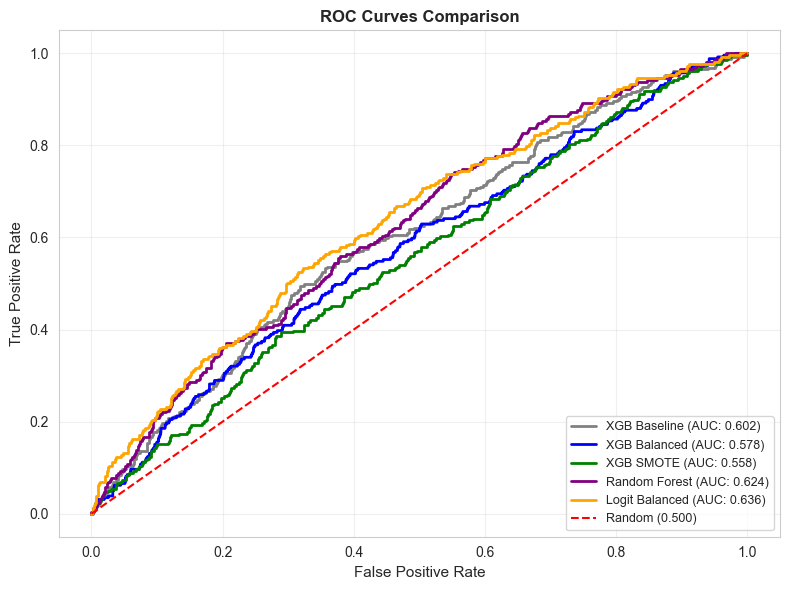

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, y_pred, color in models:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred)
    ax.plot(fpr, tpr, label=f'{name} (AUC: {auc_val:.3f})', color=color, linewidth=2)

ax.plot([0, 1], [0, 1], '--', color='red', label='Random (0.500)')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2. Índice de Gini
El coeficiente de Gini nos da una medida de la desigualdad en la distribución de las probabilidades, siendo clave en el sector financiero para medir la separación entre buenos y malos.


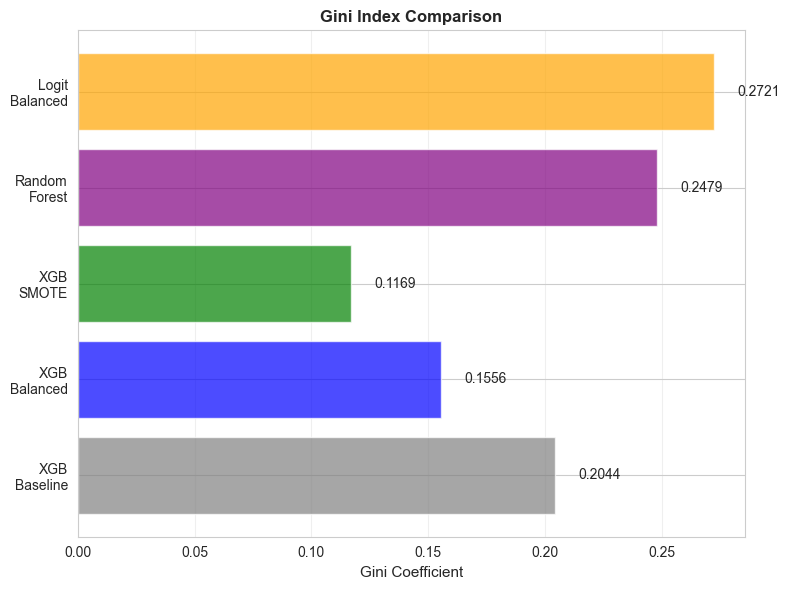

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(model_names, gini_values, color=colors_bar, alpha=0.7)
ax.set_xlabel('Gini Coefficient', fontsize=11)
ax.set_title('Gini Index Comparison', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

for i, val in enumerate(gini_values):
    ax.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 3. Estadística KS (Kolmogorov-Smirnov)
Mide la máxima separación entre las funciones de distribución acumulada de los clientes que caen en default y los que no.


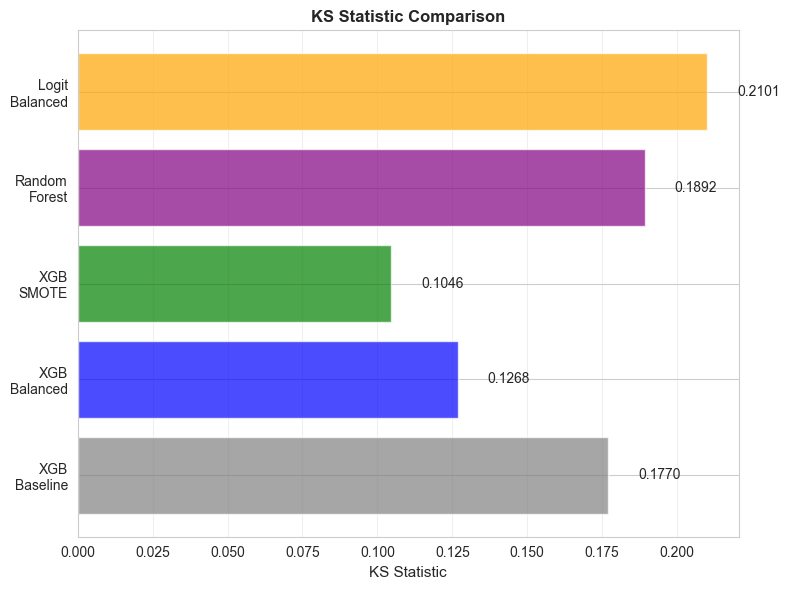

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(model_names, ks_values, color=colors_bar, alpha=0.7)
ax.set_xlabel('KS Statistic', fontsize=11)
ax.set_title('KS Statistic Comparison', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

for i, val in enumerate(ks_values):
    ax.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 5. Resumen Ejecutivo de Métricas
Tabla comparativa con los valores finales para la toma de decisiones.


In [25]:
import pandas as pd

# Crear tabla resumen
metricas_resumen = pd.DataFrame({
    'Modelo': ['XGB Baseline', 'XGB Balanced', 'XGB SMOTE', 'Random Forest', 'Logit Balanced'],
    'AUC': [auc_xgb, auc_balanced, auc_smote, auc_rf, auc_logit],
    'Gini': [gini_xgb, gini_balanced, gini_smote, gini_rf, gini_logit],
    'KS': [ks_xgb, ks_balanced, ks_smote, ks_rf, ks_logit]
})

metricas_resumen = metricas_resumen.sort_values('AUC', ascending=False)

print("\n" + "=" * 60)
print("RESUMEN DE MÉTRICAS - TODOS LOS MODELOS")
print("=" * 60)
print(metricas_resumen.to_string(index=False, float_format="%.4f"))


RESUMEN DE MÉTRICAS - TODOS LOS MODELOS
        Modelo    AUC   Gini     KS
Logit Balanced 0.6361 0.2721 0.2101
 Random Forest 0.6239 0.2479 0.1892
  XGB Baseline 0.6022 0.2044 0.1770
  XGB Balanced 0.5778 0.1556 0.1268
     XGB SMOTE 0.5585 0.1169 0.1046


### 6. Análisis Local: Matrices de Confusión
Revisamos el detalle de los errores (Falsos Positivos y Falsos Negativos) para cada modelo usando un umbral estándar de 0.5.


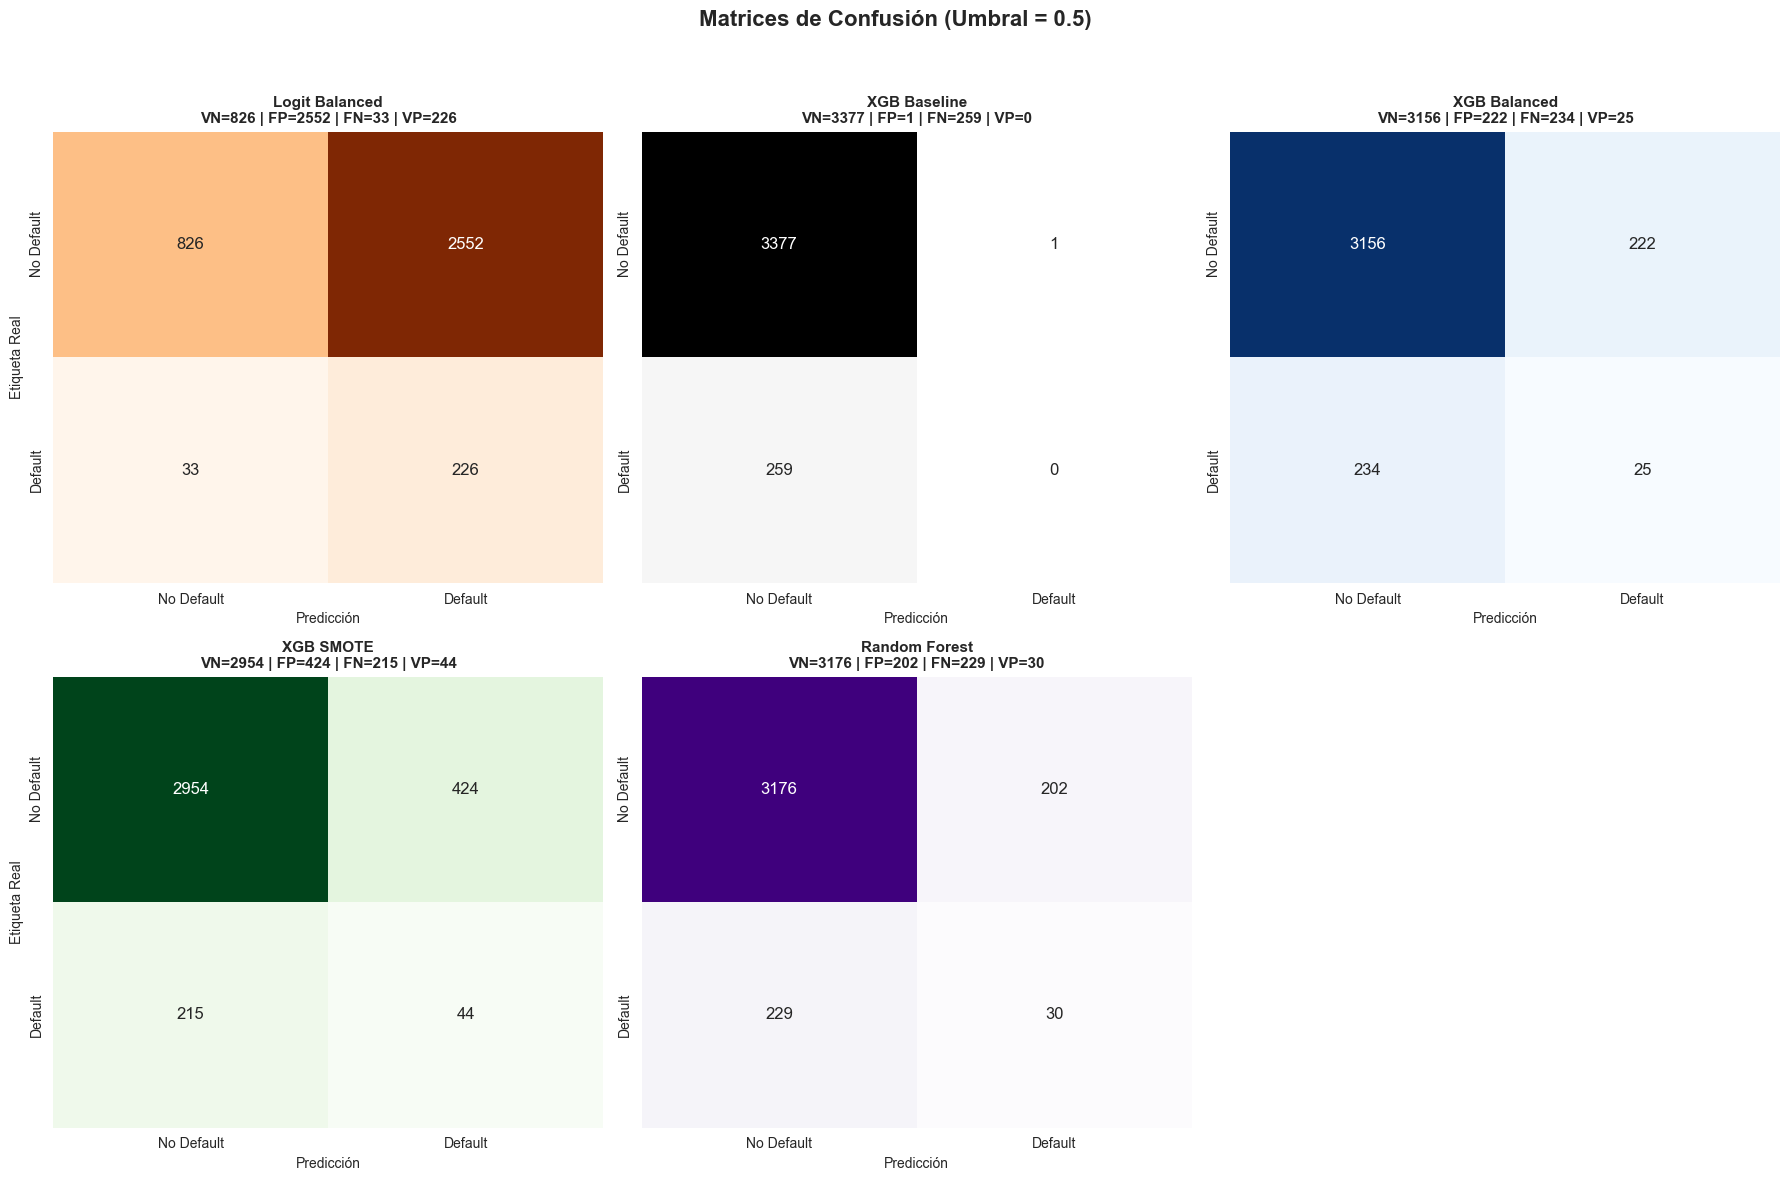

In [26]:
import matplotlib.pyplot as plt

# Definimos el umbral estándar para la clasificación
threshold = 0.5

# Lista de configuración para iterar (Nombre, Predicciones, Paleta de colores)
# Asegúrate de que las variables y_pred_* existen en tu memoria
models_cm = [
    ('Logit Balanced', y_pred_logit_balanced, 'Oranges'),
    ('XGB Baseline', y_pred_xgb, 'Greys'),
    ('XGB Balanced', y_pred_balanced, 'Blues'),
    ('XGB SMOTE', y_pred_smote, 'Greens'),
    ('Random Forest', y_pred_rf, 'Purples')
]

# Creamos la figura: 2 filas, 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Matrices de Confusión (Umbral = {threshold})', fontsize=16, fontweight='bold')

# "Aplanamos" la matriz de ejes para poder iterar fácilmente (de 2D a 1D)
axes_flat = axes.flatten()

for i, (name, y_pred_proba, cmap) in enumerate(models_cm):
    ax = axes_flat[i]

    # 1. Calcular predicción binaria y matriz
    y_pred_class = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)

    # 2. Extraer valores
    tn, fp, fn, tp = cm.ravel()

    # 3. Graficar Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'],
                ax=ax, cbar=False, annot_kws={"size": 12}) # cbar=False para limpiar, annot_kws para tamaño num

    # 4. Estética del subplot
    ax.set_title(f'{name}\nVN={tn} | FP={fp} | FN={fn} | VP={tp}',
                 fontsize=11, fontweight='bold')
    ax.set_ylabel('Etiqueta Real' if i % 3 == 0 else '') # Solo etiqueta Y en la primera columna
    ax.set_xlabel('Predicción')

# --- Manejo del espacio sobrante ---
# Como tenemos 5 modelos y 6 espacios, ocultamos el último (índice 5)
axes_flat[5].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste

In [27]:
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_balanced.fit(X_train, y_train)
y_pred_rf = rf_balanced.predict_proba(X_test)[:, 1]

# --- Cálculo de Métricas ---
auc_rf = roc_auc_score(y_test, y_pred_rf)
gini_rf = 2 * auc_rf - 1

# Cálculo de KS y búsqueda del Umbral Óptimo
scores_rf_0 = y_pred_rf[y_test == 0]
scores_rf_1 = y_pred_rf[y_test == 1]
ks_rf_stat = stats.ks_2samp(scores_rf_0, scores_rf_1)
ks_rf = ks_rf_stat.statistic

# Encontrar el umbral donde el KS es máximo (opcional pero recomendado)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
ks_curve_rf = tpr_rf - fpr_rf
idx_max_ks_rf = np.argmax(ks_curve_rf)
best_thresh_rf = thresholds_rf[idx_max_ks_rf]

print(f"\nResultados Random Forest:")
print(f"AUC:  {auc_rf:.4f}")
print(f"Gini: {gini_rf:.4f}")
print(f"KS:   {ks_rf:.4f}")
print(f"Umbral Óptimo (KS): {best_thresh_rf:.4f}")

# Matriz con el umbral óptimo
y_pred_class_rf_opt = (y_pred_rf >= best_thresh_rf).astype(int)
print("Matriz de Confusión (Umbral Óptimo):")
print(confusion_matrix(y_test, y_pred_class_rf_opt))


Resultados Random Forest:
AUC:  0.6239
Gini: 0.2479
KS:   0.1892
Umbral Óptimo (KS): 0.3513
Matriz de Confusión (Umbral Óptimo):
[[1526 1852]
 [  68  191]]


In [28]:
logit_balanced = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

logit_balanced.fit(X_train_red_scaled, y_train)
y_pred_logit_balanced = logit_balanced.predict_proba(X_test_red_scaled)[:, 1]

# --- Cálculo de Métricas ---
auc_logit = roc_auc_score(y_test, y_pred_logit_balanced)
gini_logit = 2 * auc_logit - 1

# Cálculo de KS y búsqueda del Umbral Óptimo
scores_logit_0 = y_pred_logit_balanced[y_test == 0]
scores_logit_1 = y_pred_logit_balanced[y_test == 1]
ks_logit_stat = stats.ks_2samp(scores_logit_0, scores_logit_1)
ks_logit = ks_logit_stat.statistic

# Encontrar el umbral donde el KS es máximo
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_logit_balanced)
ks_curve_log = tpr_log - fpr_log
idx_max_ks_log = np.argmax(ks_curve_log)
best_thresh_log = thresholds_log[idx_max_ks_log]

print(f"\nResultados Logit Balanced:")
print(f"AUC:  {auc_logit:.4f}")
print(f"Gini: {gini_logit:.4f}")
print(f"KS:   {ks_logit:.4f}")
print(f"Umbral Óptimo (KS): {best_thresh_log:.4f}")

# Matriz con el umbral óptimo
y_pred_class_log_opt = (y_pred_logit_balanced >= best_thresh_log).astype(int)
print("Matriz de Confusión (Umbral Óptimo):")
print(confusion_matrix(y_test, y_pred_class_log_opt))


Resultados Logit Balanced:
AUC:  0.6361
Gini: 0.2721
KS:   0.2101
Umbral Óptimo (KS): 0.6395
Matriz de Confusión (Umbral Óptimo):
[[2314 1064]
 [ 123  136]]


## Decisión final: elegir Logit Balanced (Regresión Logística) con umbral 0.64

Después de comparar los modelos, elijo Logit Balanced porque es el que mejor equilibra el negocio con el riesgo.

Random Forest detecta más defaults, pero lo hace rechazando demasiados clientes. En la práctica, eso significa perder muchas ventas y rechazar a mucha gente que sí iba a pagar. Para que esa estrategia valga la pena, cada default tendría que costar muchísimo más que la ganancia de un cliente bueno, y normalmente no es así.

En cambio, Logit Balanced con el umbral ajustado a 0.64 es más rentable y más realista para originación:
- Aprueba muchos más clientes (más colocación).
- Rechaza menos clientes buenos (menos pérdida comercial).
- Aun así mantiene una protección razonable contra el default.
- Además, es un modelo más estable y fácil de explicar, lo cual ayuda para seguimiento y decisiones de negocio.

Regla de negocio (corte 0.64, o 0.65 si quiero ser más conservador):
- Si probabilidad_predicha >= 0.64 -> RECHAZAR (Alto Riesgo)
- Si probabilidad_predicha < 0.64 -> APROBAR (Bajo Riesgo)

Con este ajuste, pasamos de modelos que no ayudaban (uno que no veía el riesgo y otro que rechazaba casi todo) a una herramienta calibrada que busca maximizar la rentabilidad sin perder el control del riesgo.

# Análisis de cosechas


In [30]:
eval_df = apps_model.copy()

eval_df['pd'] = logit_balanced.predict_proba(
    scaler.transform(eval_df[good_vars])
)[:, 1]

# cohorte por mes de originación
eval_df['cohort'] = eval_df['orig_month'].dt.to_period('M')




C:\Users\leo_m\.conda\envs\Prueba-Monex\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [31]:
cohort_table = (
    eval_df
    .groupby('cohort')
    .agg(
        avg_pd=('pd', 'mean'),
        real_default=('default_12m', 'mean'),
        total_amount=('amount', 'sum'),
        n_clients=('customer_id', 'count')
    )
)

cohort_table


,avg_pd,real_default,total_amount,n_clients
cohort,,,,
2022-01,0.447930,0.041371,4.910012e+08,7179
2023-01,0.496126,0.060270,4.754772e+08,7035
2024-01,0.573800,0.072887,2.936908e+08,4212


In [32]:
early = cohort_table.head(2)
recent = cohort_table.tail(2)

print("Cosechas tempranas:\n", early)
print("\nCosechas recientes:\n", recent)


Cosechas tempranas:
            avg_pd  real_default  total_amount  n_clients
cohort                                                  
2022-01  0.447930      0.041371  4.910012e+08       7179
2023-01  0.496126      0.060270  4.754772e+08       7035

Cosechas recientes:
            avg_pd  real_default  total_amount  n_clients
cohort                                                  
2023-01  0.496126      0.060270  4.754772e+08       7035
2024-01  0.573800      0.072887  2.936908e+08       4212


## Percentiles de PD

In [33]:
eval_df['pd_percentile'] = pd.qcut(eval_df['pd'], 10, labels=False)


In [34]:
percentile_table = (
    eval_df
    .groupby('pd_percentile')
    .agg(
        avg_pd=('pd', 'mean'),
        real_default=('default_12m', 'mean'),
        total_amount=('amount', 'sum'),
        n_clients=('customer_id', 'count')
    )
)

percentile_table['expected_loss'] = (
    percentile_table['avg_pd'] * percentile_table['total_amount']
)

percentile_table


,avg_pd,real_default,total_amount,n_clients,expected_loss
pd_percentile,,,,,
0,0.283965,0.025502,1.187594e+08,1843,3.372346e+07
1,0.359863,0.027672,1.242678e+08,1843,4.471938e+07
2,0.404480,0.030945,1.253149e+08,1842,5.068733e+07
3,0.442565,0.036354,1.305026e+08,1843,5.775583e+07
4,0.477294,0.049403,1.300713e+08,1842,6.208230e+07
5,0.510296,0.053174,1.221865e+08,1843,6.235130e+07
6,0.544738,0.057546,1.262858e+08,1842,6.879268e+07
7,0.583385,0.071080,1.284598e+08,1843,7.494156e+07
8,0.631313,0.087405,1.285853e+08,1842,8.117760e+07


In [36]:
coef = pd.Series(logit_balanced.coef_[0], index=good_vars).sort_values()
coef


bureau_score     -0.406951
income           -0.067486
infl              0.060058
utilization       0.114552
debt_income       0.121792
prev_delin_24m    0.126517
rate              0.166644
dtype: float64

In [37]:
coef.tail(5)


infl              0.060058
utilization       0.114552
debt_income       0.121792
prev_delin_24m    0.126517
rate              0.166644
dtype: float64

### Casos individuales

In [38]:
eval_df.sort_values('pd', ascending=False).head(5)


,customer_id,orig_month,age,income,debt_income,bureau_score,utilization,prev_delin_24m,tenure_months,amount,...,months_since_orig,product_CC,product_PL,channel_Digital,channel_Partner,region_N,region_S,pd,cohort,pd_percentile
954,1327,2024-01-06,37,27271.15,2.5809,560.8,0.3869,0,26,18156.51,...,12.056505,1,0,0,0,0,0,0.931804,2024-01,9
15688,21270,2024-01-04,22,24770.86,1.9488,516.9,0.7638,1,46,199664.11,...,12.122208,0,0,0,1,0,0,0.927830,2024-01,9
10846,14708,2024-01-05,37,17235.53,0.6559,610.4,0.3750,4,73,122581.64,...,12.089356,0,0,1,0,0,0,0.878098,2024-01,9
7462,10130,2024-01-06,40,24172.15,1.6572,600.0,0.5322,0,38,46064.39,...,12.056505,0,1,0,1,0,0,0.868925,2024-01,9
12028,16276,2024-01-06,36,44989.25,0.4714,512.6,0.6315,0,12,98536.79,...,12.056505,0,1,0,0,0,0,0.862946,2024-01,9


Clientes menos riesgosos:

In [39]:
eval_df.sort_values('pd').head(5)


,customer_id,orig_month,age,income,debt_income,bureau_score,utilization,prev_delin_24m,tenure_months,amount,...,months_since_orig,product_CC,product_PL,channel_Digital,channel_Partner,region_N,region_S,pd,cohort,pd_percentile
10160,13776,2022-01-01,35,53468.33,0.2842,850.0,0.4617,0,26,39154.61,...,36.202365,0,1,1,0,0,0,0.128900,2022-01,0
6478,8778,2022-01-06,43,54865.14,0.3227,850.0,0.2897,0,52,60449.98,...,36.038108,0,1,1,0,0,1,0.131345,2022-01,0
10257,13897,2022-01-06,44,17672.92,0.1712,850.0,0.2561,0,72,25750.48,...,36.038108,1,0,0,0,0,1,0.135857,2022-01,0
17737,24049,2022-01-01,42,18509.89,0.5139,847.1,0.0998,0,29,146927.96,...,36.202365,0,0,1,0,1,0,0.138313,2022-01,0
10401,14096,2022-01-04,51,29874.41,0.1229,850.0,0.2262,0,5,10536.17,...,36.103811,1,0,1,0,0,1,0.141412,2022-01,0
